In [1]:
import os
import sys
import numpy as np
import torch
import torch.distributed as dist
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.checkpoint import checkpoint
from torch.cuda.amp import autocast, GradScaler
from bitsandbytes.optim import AdamW8bit
import SimpleITK as sitk
from pytorch_msssim import ms_ssim
from templates import *

++++++++++!!!!+++++++++++
!!!!!USING 2ND MODEL??!!!!!!
!!!!!USING SEG E2E MODEL!!!!!!


/storage/kjh/cardiac/DMCVR/generation/diffae_inverse/metrics.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Model & EMA load
conf = autoenc_base()
conf.use_checkpoint = False
conf.attn_checkpoint = False
conf.img_size = 128
conf.net_ch = 128
conf.net_ch_mult = (1,1,2,3,4)
conf.net_enc_channel_mult = (1,1,2,3,4,4)
conf.model_name = ModelName.beatgans_autoenc
conf.name = 'med256_autoenc'
conf.make_model_conf()

base_model = LitModel(conf)
ckpt = torch.load(
    '/storage/kjh/cardiac/DMCVR/generation/diffae_multi_PNU/checkpoints_multi/med256_autoenc/1/epoch=438-step=756789.ckpt', map_location="cpu"
)
base_model.load_state_dict(ckpt["state_dict"], strict=True)
base_model.to(device).eval()
ema = base_model.ema_model.to(device).eval()
model = ema

Seed set to 0


>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++
>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++
>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++
Model params: 122.58 M


/tmp/ipykernel_635719/3396614839.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(


In [ ]:
# 3) Data preparation

frame = 0

# -- SAX volume
sax_path = "/storage/kjh/dataset/cardiac/PNU_cardiac/CINE/test/middle_slice/sax/MR_Heart_834_crop_sa.nii.gz"
img_sax = sitk.ReadImage(sax_path)
vol_sax = sitk.GetArrayFromImage(img_sax).astype(np.float32)  # (Z,H,W)
print(vol_sax.shape)
mx = np.percentile(vol_sax, 98)
vol_sax = np.clip(vol_sax, 0, mx) / mx * 2.0 - 1.0
vol_sax = np.flip(vol_sax, axis=-2)  # flip y
# remove zero slices
nonzero = [i for i in range(vol_sax.shape[0]) if vol_sax[i].max() != 0]
vol_sax = vol_sax[nonzero]

vol_sax = vol_sax[frame, :, :, :]

# -- GT volume (3D) and mask volume
gt_path   = "/storage/icml_data_collection/Cardiac_database/PNUH/PNUH_cine_LAX_SAX_align_2/MR_Heart_834/combine_1lax_cropped/combine_1lax_cropped_{frame}.nii.gz"
mask_path = "/storage/icml_data_collection/Cardiac_database/PNUH/PNUH_cine_LAX_SAX_align_2/MR_Heart_834/combine_1lax_mask_cropped/combine_1lax_mask_cropped_{frame}.nii.gz"
gt_vol = sitk.GetArrayFromImage(sitk.ReadImage(gt_path.format(frame=frame))).astype(np.float32)
gt_vol = np.clip(gt_vol, 0, np.nanpercentile(gt_vol, 98)) / np.nanpercentile(gt_vol, 98)
gt_vol = np.flip(gt_vol, axis=1).copy()
mask_vol = sitk.GetArrayFromImage(sitk.ReadImage(mask_path.format(frame=frame))).astype(bool)
mask_vol = np.flip(mask_vol, axis=1).copy()

print(gt_vol.shape)
print(mask_vol.shape)

# convert to torch
sax_tensor = torch.from_numpy(vol_sax).float().unsqueeze(1).to(device)    # (Z,1,H,W)
gt_tensor  = torch.from_numpy(gt_vol).float().unsqueeze(1).to(device)      # (Z,1,H,W)
mask_tensor= torch.from_numpy(mask_vol).float().unsqueeze(1).to(device)    # (Z,1,H,W)

(25, 11, 128, 128)
(81, 128, 128)
(81, 128, 128)


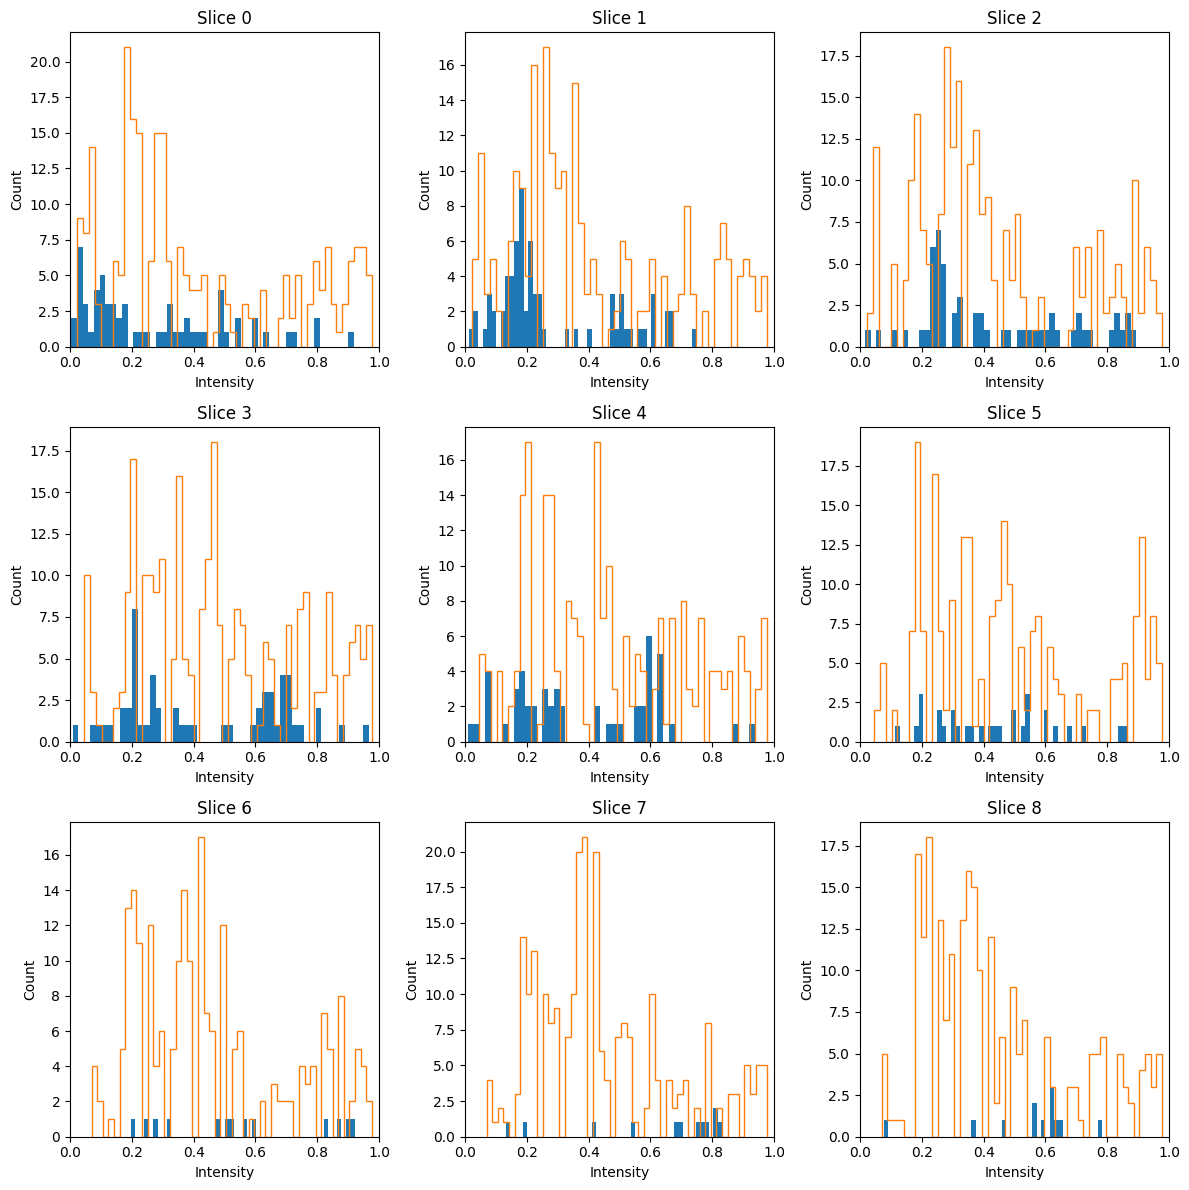

In [ ]:
# # 주황색 : GT, 파란색 : pred

# import matplotlib.pyplot as plt
# import numpy as np

# # preds: torch.Tensor, shape (81,1,128,128)
# # gt_vol: numpy array or torch.Tensor, shape (81,128,128)
# # 먼저 numpy array로 변환
# # preds_np = roi_pred.squeeze(1).cpu().detach().numpy()  # (81,128,128)
# preds_np = vol_sax
# import torch as _torch
# gt_np = roi_gt.squeeze(1).cpu().detach().numpy()  # (81,128,128)

# # 시각화할 슬라이스 개수 (예: 첫 9장)
# n_display = min(9, preds_np.shape[0])
# fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# for idx, ax in enumerate(axs.flatten()):
#     if idx < n_display:
#         # Pred/GT 값 중 0보다 큰 영역만 추출해서 비교
#         sax_roi = preds_np[idx] * mask_vol[idx * 8]
#         pred_vals = sax_roi.flatten()
#         pred_vals = pred_vals[(pred_vals > 0) & (pred_vals < 1)]
#         # pred_vals = pred_vals[(pred_vals > 0)]
#         gt_vals   = gt_np   [idx * 8].flatten()
#         gt_vals   = gt_vals  [(gt_vals   > 0) & (gt_vals   < 1)]
#         # gt_vals   = gt_vals  [(gt_vals   > 0)]
#         ax.hist(pred_vals, bins=50)
#         ax.hist(gt_vals,   bins=50, histtype='step')
#         ax.set_title(f"Slice {idx}")
#         ax.set_xlim(0, 1)
#         ax.set_ylabel("Count")
#         ax.set_xlabel("Intensity")
#     else:
#         ax.axis('off')

# plt.tight_layout()
# plt.show()


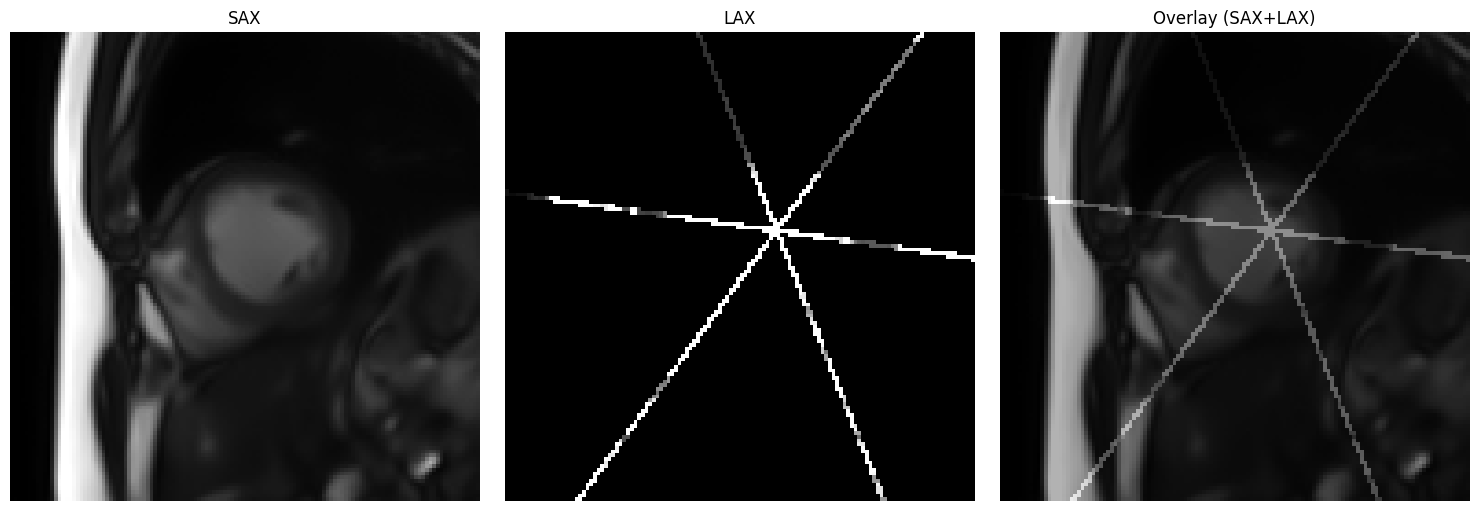

In [108]:
import matplotlib.pyplot as plt
import numpy as np

middle_sax = preds.detach().cpu().numpy().squeeze(1)[40,:,:]
middle_lax = gt_vol[40,:,:]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# 1) SAX
axs[0].imshow(middle_sax, cmap='gray')
axs[0].set_title('SAX')
axs[0].axis('off')
# 2) LAX
axs[1].imshow(middle_lax, cmap='gray')
axs[1].set_title('LAX')
axs[1].axis('off')
# 3) Overlay
axs[2].imshow(0.7 * middle_sax + 0.3 * middle_lax, cmap='gray')
axs[2].set_title('Overlay (SAX+LAX)')
axs[2].axis('off')
plt.tight_layout()
plt.show()

In [83]:
# encode + stochastic encode
cond = base_model.encode(sax_tensor)
xTs = base_model.encode_stochastic(sax_tensor, cond, T=30)

/usr/local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.8/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/storage/kjh/cardiac/DMCVR/generation/diffae_inverse/diffusion/base.py:406: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(self.conf.fp16):


In [84]:
def slerp(a: torch.Tensor, b: torch.Tensor, t: float) -> torch.Tensor:
    omega = torch.acos((a * b).sum() / (a.norm() * b.norm()))
    return (torch.sin((1-t)*omega)*a + torch.sin(t*omega)*b) / torch.sin(omega)
# build sequences directly on Torch tensors
filling = 8
xs, cs = [], []
N = xTs.shape[0]
for i in range(N - 1):
    a, b = xTs[i], xTs[i+1]
    ca, cb = cond[i], cond[i+1]
    xs.append(a); cs.append(ca)
    for alpha in np.linspace(0, 1, filling, endpoint=False)[1:]:
        xs.append(slerp(a, b, float(alpha)))
        cs.append(ca * (1 - alpha) + cb * alpha)
# 마지막 포인트 추가
xs.append(xTs[-1]); cs.append(cond[-1])
# stack, move to device, enable grad
interp_xTs = torch.stack(xs, dim=0).to(device).requires_grad_(True)
interp_cs  = torch.stack(cs,  dim=0).to(device).requires_grad_(True)

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sax_lax(sax_preds, lax_preds, mask_batch, num_display=None):
    """
    sax_preds  : torch.Tensor, shape = (B,1,H,W)
    lax_preds  : torch.Tensor, shape = (B,1,H,W)
    mask_batch : torch.Tensor, shape = (B,1,H,W)  # binary mask
    num_display: int or None
    """
    # CPU / numpy 로 변환
    sax_np  = sax_preds .cpu().detach().numpy()[:,0]   # (B,H,W)
    lax_np  = lax_preds .cpu().detach().numpy()[:,0]   # (B,H,W)
    mask_np = mask_batch.cpu().detach().numpy()[:,0].astype(bool)  # (B,H,W)

    print(sax_np.shape)
    print(lax_np.shape)
    print(mask_np.shape)

    B = sax_np.shape[0]
    if num_display is None or num_display > B:
        num_display = B

    for i in range(num_display):
        sax_i = sax_np[i]
        lax_i = lax_np[i]
        m_i   = mask_np[i]

        # mask 테두리만 추출 (simple morphological edge)
        edge = m_i & ~(
            np.roll(m_i, 1, axis=0) &
            np.roll(m_i, -1, axis=0) &
            np.roll(m_i, 1, axis=1) &
            np.roll(m_i, -1, axis=1)
        )
        ys, xs = np.where(edge)

        # overlay: SAX 와 LAX 단순 평균
        overlay = 0.5 * sax_i + 0.5 * lax_i

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # 1) SAX
        axs[0].imshow(sax_i, cmap='gray')
        axs[0].plot(xs, ys, 'r.', markersize=1)
        axs[0].set_title('SAX')
        axs[0].axis('off')

        # 2) LAX
        axs[1].imshow(lax_i, cmap='gray')
        axs[1].plot(xs, ys, 'r.', markersize=1)
        axs[1].set_title('LAX')
        axs[1].axis('off')

        # 3) Overlay
        axs[2].imshow(overlay, cmap='gray')
        axs[2].plot(xs, ys, 'r.', markersize=1)
        axs[2].set_title('Overlay (SAX+LAX)')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()


In [85]:
preds = base_model.render(interp_xTs, interp_cs, 30)  # (D,1,H,W)

mask_batch = mask_tensor  # → (B,1,H,W)
gt_batch   = gt_tensor    # → (B,1,H,W
# 2) 한 번에 ROI 적용
roi_pred = preds * mask_batch     # → (B,1,H,W)
roi_gt   = gt_batch * mask_batch  # → (B,1,H,W)



In [86]:
print( roi_pred.min(), roi_pred.max() )
print( roi_gt.min(), roi_gt.max() )

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9993, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [ ]:
visualize_sax_lax(preds, gt_batch, mask_batch, num_display=20)